In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configurazione Iniziale ---
FOLDER = '300ml'

STEP_TEMPORALE_S = 1.0  # Definire il passo temporale se non già presente

total = pd.DataFrame()  # DataFrame vuoto per accumulare i dati

for FILENAME in ['forno.csv', 'ghiaccio.csv']:

    FILE_PATH = os.path.join(FOLDER, FILENAME)
    
    df = pd.read_csv(FILE_PATH)

    df.columns = ['Timestamp_Raw', 'Temp_K', 'Hum_Pct', 'Pres_kPa']

    regex_num = r'(\d+\.?\d*)' 

    df['Temperatura'] = df['Temp_K'].astype(str).str.extract(regex_num).astype(float) - 273.15
    df['Umidita'] = df['Hum_Pct'].astype(str).str.extract(regex_num).astype(float)
    df['Pressione'] = df['Pres_kPa'].astype(str).str.extract(regex_num).astype(float)
    df.dropna(subset=['Temperatura', 'Umidita', 'Pressione'], inplace=True)

    df['Tempo_Simulato_s'] = np.arange(len(df)) * STEP_TEMPORALE_S

    # --- Logica Condizionale per Filtraggio ---

# --- Logica Condizionale per Filtraggio ---
    if FILENAME == 'forno.csv':
        mask_to_remove = (df['Tempo_Simulato_s'] <= 2000) | (df['Tempo_Simulato_s'] >= 8000)
        df = df[~mask_to_remove].copy()

    elif FILENAME == 'ghiaccio.csv':
        mask_to_remove = (df['Tempo_Simulato_s'] <= 5000) 
        df = df[~mask_to_remove].copy()

    elif FILENAME == 'frigo.csv':
        mask_to_remove = (df['Tempo_Simulato_s'] <= 1500) | (df['Tempo_Simulato_s'] >= 10000)
        df = df[~mask_to_remove].copy()

    elif FILENAME == '24h.csv':
        mask_to_remove = (df['Tempo_Simulato_s'] <= 20000) | \
                         ((df['Tempo_Simulato_s'] >= 50000))
        df = df[~mask_to_remove].copy()


    print(f"Processed {FILENAME}: {len(df)} valid entries after filtering.")
    
    # voglio un unico dataframe con tutti i dati 
    total = pd.concat([total, df], ignore_index=True)

print("All files processed. lunghezza totale dataframes_list:", len(total))

#rinomino total come df per continuare con lo stesso codice
df = total.copy()
    

Processed forno.csv: 5999 valid entries after filtering.
Processed ghiaccio.csv: 46062 valid entries after filtering.
All files processed. lunghezza totale dataframes_list: 52061


In [7]:

# --- CONFIGURAZIONE INCERTEZZE ---
u_P_kpa = 0.1     # kPa
u_T_c = 1.0       # °C
u_UR_pct = 4.0    # %
u_V_ml = 3.0      # ml

volume_ml = 1015.0 # Volume nominale tolto elettronica 

# --- PREPARAZIONE DATI (SI) ---

p_tot_pa = df['Pressione'] * 1000.0       # kPa -> Pa
t_c_series = df['Temperatura'] 
ur_pct_series = df['Umidita']

# --- DEFINIZIONE LOGICA FISICA (Helper Vettoriale) ---
def core_physics_vectorized(p_pa, t_c, ur_pct, v_ml):
    # 1. Costanti
    Rd = 287.058    # J/kgK (Aria secca)
    Rv = 461.495    # J/kgK (Vapore)
    Md = 0.028964   # kg/mol (Aria secca)
    Mv = 0.018015   # kg/mol (Acqua)
    
    # 2. Variabili derivate locali
    tk = t_c + 273.15       # Ricalcolato qui per seguire le perturbazioni di T
    v_m3 = v_ml * 1e-6 
    
    # 3. Pressioni (Magnus-Tetens)
    # Es: Pressione vapore saturo
    es_hpa = 6.112 * np.exp((17.67 * t_c) / (t_c + 243.5))
    es_pa = es_hpa * 100.0
    
    # Pressione parziale vapore e aria secca
    p_vap = es_pa * (ur_pct / 100.0)
    p_dry = p_pa - p_vap
    
    # 4. Densità (rho = P / R*T)
    rho_d = p_dry / (Rd * tk)
    rho_v = p_vap / (Rv * tk)
    densita_tot = rho_d + rho_v
    
    # 5. Moli (n = rho * V / MM)
    n_d = (rho_d * v_m3) / Md
    n_v = (rho_v * v_m3) / Mv
    n_tot = n_d + n_v
    
    return n_tot, densita_tot

# --- 1. CALCOLO NOMINALE ---
n_nominale, rho_nominale = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml)

# --- 2. PROPAGAZIONE ERRORI (Metodo Numerico) ---

# A. Perturbazione Pressione (Attenzione: u_P in kPa -> convertire in Pa)
n_p, rho_p = core_physics_vectorized(p_tot_pa + (u_P_kpa * 1000.0), t_c_series, ur_pct_series, volume_ml)
dn_dP = n_p - n_nominale
drho_dP = rho_p - rho_nominale

# B. Perturbazione Temperatura
n_t, rho_t = core_physics_vectorized(p_tot_pa, t_c_series + u_T_c, ur_pct_series, volume_ml)
dn_dT = n_t - n_nominale
drho_dT = rho_t - rho_nominale

# C. Perturbazione Umidità
n_ur, rho_ur = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series + u_UR_pct, volume_ml)
dn_dUR = n_ur - n_nominale
drho_dUR = rho_ur - rho_nominale

# D. Perturbazione Volume
n_v, rho_v = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml + u_V_ml)
dn_dV = n_v - n_nominale
drho_dV = rho_v - rho_nominale

# --- 3. COMBINAZIONE RSS (Root Sum Square) ---
u_n_tot = np.sqrt(dn_dP**2 + dn_dT**2 + dn_dUR**2 + dn_dV**2)
u_rho_tot = np.sqrt(drho_dP**2 + drho_dT**2 + drho_dUR**2 + drho_dV**2)

# --- 4. SALVATAGGIO RISULTATI ---
# Aggiungiamo direttamente le colonne al dataframe esistente o ne creiamo uno nuovo
df_risultati = pd.DataFrame({
    'Moli': n_nominale,
    'Err_Moli': u_n_tot,
    'Densita': rho_nominale,
    'Err_Densita': u_rho_tot
})

# Visualizza prime righe
print(df_risultati)

           Moli  Err_Moli   Densita  Err_Densita
0      0.038510  0.000162  1.098151     0.007076
1      0.038509  0.000162  1.098121     0.007076
2      0.038508  0.000162  1.098091     0.007076
3      0.038508  0.000162  1.098081     0.007076
4      0.038507  0.000162  1.098051     0.007076
...         ...       ...       ...          ...
52056  0.042229  0.000198  1.200329     0.004668
52057  0.042228  0.000198  1.200317     0.004668
52058  0.042229  0.000198  1.200345     0.004668
52059  0.042230  0.000198  1.200357     0.004668
52060  0.042228  0.000198  1.200296     0.004668

[52061 rows x 4 columns]


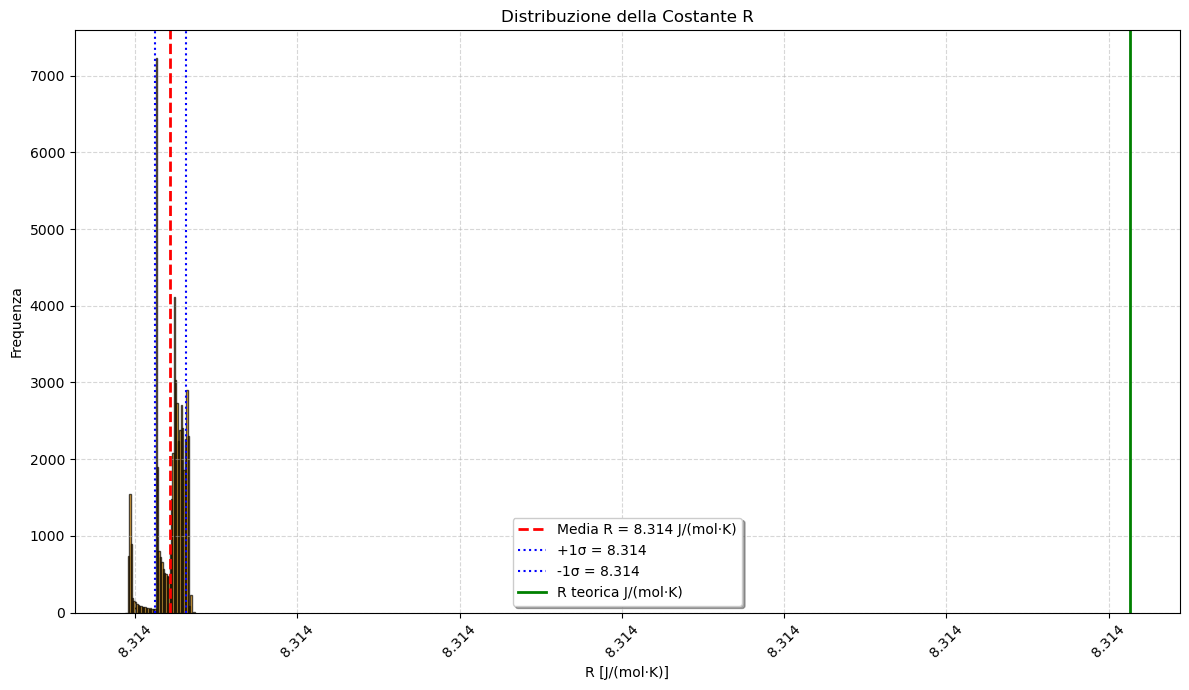

Media pesata di R: 8.31434424 ± 2.42713856e-04 J/(mol·K)


In [ ]:
# Assicuriamoci che siano nelle stesse unità di misura usate nel calcolo di R
sigma_P_pa = u_P_kpa * 1000.0
sigma_V_m3 = u_V_ml * 1e-6
sigma_T_k  = u_T_c 
sigma_n  = df_risultati['Err_Moli'].mean()

P = df['Pressione'] * 1000.0
V = volume_ml * 1e-6
n = df_risultati['Moli'].mean()
T = (df['Temperatura'] + 273.15)

# R calcolato
R = (P * V) / (n * T)

# 3. Calcolo dell'errore associato ad ogni istanza di R (Propagazione)
# Usiamo la formula delle derivate prime (quadratica per variabili indipendenti)
err_R = R * np.sqrt(
    (sigma_P_pa / P)**2 +
    (sigma_V_m3 / V)**2 +
    (sigma_n / n)**2 +
    (sigma_T_k / T)**2
)

# 4. Aggiornamento DataFrame
df_R = pd.DataFrame({
    'R': R,
    'Err_R': err_R
})

# 3. Statistiche
mean_R = df_R['R'].mean()
std_R = df_R['R'].std()

# 4. Plotting
plt.figure(figsize=(12, 7))
plt.hist(df_R['R'], bins=50, color='orange', edgecolor='black', alpha=0.7)

# Linee statistiche con alta precisione nei label
plt.axvline(mean_R, color='red', linestyle='dashed', linewidth=2, 
            label=f'Media R = {mean_R:.3f} J/(mol·K)')
plt.axvline(mean_R + std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'+1σ = {mean_R + std_R:.3f}')
plt.axvline(mean_R - std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'-1σ = {mean_R - std_R:.3f}')
plt.axvline(8.314462618, color='green', linestyle='solid', linewidth=2, 
            label='R teorica J/(mol·K)')

# --- FIX ASSE X (Rimuove l'offset 1e-7 + 8.314...) ---
ax = plt.gca()

import matplotlib.ticker as ticker

# Forza la visualizzazione dei valori assoluti senza offset
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# Specifica il numero di decimali da mostrare per apprezzare la dispersione
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

plt.title('Distribuzione della Costante R')
plt.xlabel('R [J/(mol·K)]')
plt.ylabel('Frequenza')
plt.xticks(rotation=45) # Ruota per evitare sovrapposizioni date dall'alta precisione
plt.legend(loc='best', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#media pesata degli R
weights = 1 / (df_R['Err_R'] ** 2)
weighted_mean_R = np.sum(df_R['R'] * weights) / np.sum(weights)
weighted_std_R = np.sqrt(1 / np.sum(weights))   
print(f"Media pesata di R: {weighted_mean_R:.8f} ± {weighted_std_R:.8e} J/(mol·K)")



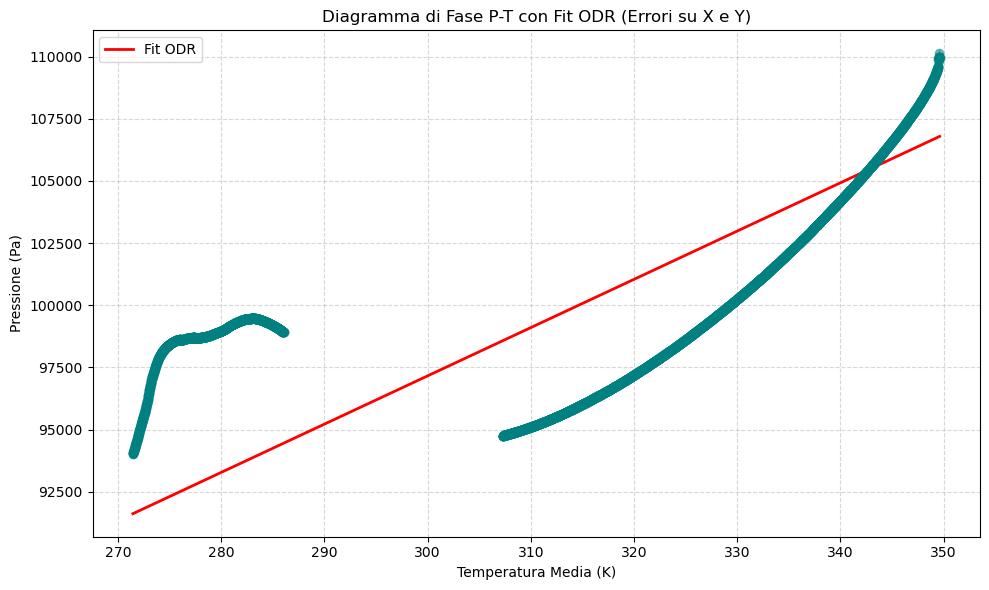

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)   : 194.1297 ± 2.8824 Pa/K
Intercetta Y (q): 38924.2969 ± 904.8911 Pa
------------------------------
Temperatura allo zero di Pressione:
T(P=0) = -200.51 ± 0.43 K
------------------------------
------------------------------
VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K
------------------------------
Compatibilità in termini di σ: 184.35 σ


In [9]:
from scipy import odr

# Raggruppo per Temperatura e medio la Pressione
# Nota: Groupby Temperatura riduce il rumore sulla variabile dipendente P
df_PT = df[['Pressione', 'Temperatura']].groupby('Temperatura').mean().reset_index()

# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values + 273.15  # converto in Kelvin per il fit
y = df_PT['Pressione'].values * 1000.0    # kPa -> Pa

# 2. Configurazione ODR (Orthogonal Distance Regression)
# Definisco il modello lineare: y = m*x + q (B[0]=slope, B[1]=intercept)
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])

# Creo l'oggetto RealData con le incertezze costanti (sx=1, sy=0.1)
my_data = odr.RealData(x, y, sx=1.0, sy=100)

#inizializo
my_odr = odr.ODR(my_data, linear_model, beta0=[0.1, 90])

# Eseguo il fit
output = my_odr.run()

# Estraggo parametri e incertezze (Deviazione Standard)
m, q = output.beta          # m = pendenza, q = intercetta Y
sm, sq = output.sd_beta     # incertezze su m e q
cov = output.cov_beta       # matrice di covarianza (necessaria per prop. errore)

# 3. Calcolo Temperatura a Pressione 0 (Intercetta asse X)
T0 = -q / m

# Propagazione dell'errore per T0 
deriv_q = -1 / m
deriv_m = q / (m**2)

var_T0 = (deriv_q**2 * output.cov_beta[1, 1] + 
          deriv_m**2 * output.cov_beta[0, 0] + 
          2 * deriv_q * deriv_m * output.cov_beta[0, 1])

sT0 = np.sqrt(var_T0)

# 4. Plotting 
plt.figure(figsize=(10, 6))

# Dati con barre d'errore
# plotto con errori nulli per evidenziare i punti senza barre d'errore
plt.errorbar(x, y, xerr=0, yerr=0, fmt='o', 
             color='teal', ecolor='teal', alpha=0.5, capsize=2)

# Retta di fit
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fit ODR')

plt.title('Diagramma di Fase P-T con Fit ODR (Errori su X e Y)')
plt.ylabel('Pressione (Pa)')
plt.xlabel('Temperatura Media (K)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Risultati
print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)   : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura allo zero di Pressione:")
print(f"T(P=0) = {T0:.2f} ± {sT0:.2f} K")
print("-" * 30)

sigma_syst_T = 1.0  # Gradi Kelvin/Celsius (Accuratezza assoluta)
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

# 6. compatibilità con zero assoluto 
print("-" * 30)
print("VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K")
print("-" * 30)
zero_assoluto = 0
diff_T0_zero_assoluto = abs(T0 - zero_assoluto)
comp = diff_T0_zero_assoluto / sT0_total
print(f"Compatibilità in termini di σ: {comp:.2f} σ")    
